In [1]:
# cài đặt thư viện cần thiết
# !pip install sklearn fuzzy-c-means
# load thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from fcmeans import FCM
import pickle
# random state
rs = 12

In [2]:
# đọc dữ liệu
df = pd.read_csv('../../data/rfm_data.csv')
# load trọng số lên
rfm_weight = pd.read_csv('../../data/rfm_weight.csv')
rfm_weight

,variable,weight
0,Recency,0.137
1,Frequency,0.328
2,Moneytary,0.535


In [3]:
# Retrieval RFM weights
w = rfm_weight.set_index('variable').to_dict()['weight']
# weighted RFM
df.iloc[:, 1:] = df.iloc[:, 1:].apply(lambda x: x * w[x.name])


## Chuẩn bị dữ liệu

In [4]:
cust_id = df.iloc[:, 0].values
X = df.iloc[:, 1:].values
cust_id, X

(array([101000281, 101000282, 101000283, ..., 106000306, 106001293,
        106001527]),
 array([[0.02213077, 0.0033641 , 0.09640134],
        [0.08536154, 0.00168205, 0.03321054],
        [0.02529231, 0.00252308, 0.03592002],
        ...,
        [0.03688462, 0.00084103, 0.0136741 ],
        [0.0274    , 0.        , 0.01963496],
        [0.10749231, 0.        , 0.00385662]]))

# Phân cụm

## KMeans

In [5]:
# dùng thang đo silhouette để chọn số cụm
# để số cụm từ 2 -> 10
range_k = np.arange(3, 4)
range_k

array([3])

In [6]:
def make_kmean(k: int):
    model = KMeans(n_clusters=k, random_state=rs)
    model.fit(X)
    cluster_labels = model.predict(X)
    sil_score = silhouette_score(X, cluster_labels)
    print(f"K: {k} done")
    return dict(
        k=k,
        cluster_labels=cluster_labels,
        sil_score=sil_score
    )

In [7]:
kmean_final_cluster = [make_kmean(k) for k in range_k]

K: 3 done


Plot kmeans model

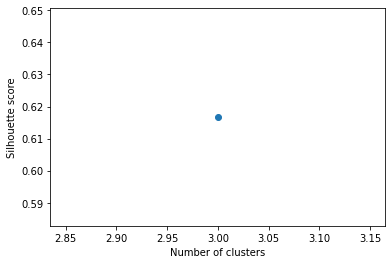

In [8]:
sil_scores = np.array([i['sil_score'] for i in kmean_final_cluster])
plt.plot(range_k, sil_scores)
plt.scatter(range_k, sil_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.savefig('Kmean sil plot.png')
plt.show()

In [9]:
#Sort out the best value according to the decreasing 
sorted_kmean_final_cluster = sorted(kmean_final_cluster, key=lambda x: x['sil_score'], reverse=True)
sorted_kmean_final_cluster

[{'k': 3,
  'cluster_labels': array([2, 0, 1, ..., 1, 1, 0], dtype=int32),
  'sil_score': 0.6167014908687777}]

In [10]:
# Take the best model with the largest sihouette score
best_k_kmean = sorted_kmean_final_cluster[0]['k']
kmean_cluster_labels = sorted_kmean_final_cluster[0]['cluster_labels']
kmean_sil_score = sorted_kmean_final_cluster[0]['sil_score']
print(f'Số cụm tốt nhất cho KMeans là {best_k_kmean} với giá trị sihouette: {kmean_sil_score}')

Số cụm tốt nhất cho KMeans là 3 với giá trị sihouette: 0.6167014908687777


In [11]:
# Recluster the model
best_k_kmean = 3
print(f"Chạy model với K = {best_k_kmean} cho K Means")
kmean_model = KMeans(n_clusters=best_k_kmean, random_state=rs)
kmean_model.fit(X)

# Save the model
with open('../../data/kmean_model.pkl', 'wb') as f:
    pickle.dump(kmean_model, f, pickle.HIGHEST_PROTOCOL)

kmean_cluster_df = pd.DataFrame(
    {'User number': cust_id, 'Cluster Label': kmean_cluster_labels}
)
df_merged_kmean = df.merge(kmean_cluster_df, on='User number')
df_merged_kmean.to_csv('../../data/cluster_kmeans.csv', index=False)

Chạy model với K = 3 cho K Means


In [12]:
print("Trung bình giá trị trên mỗi cụm của KMeans")
df_merged_kmean.groupby('Cluster Label').mean().iloc[:, 1:]

Trung bình giá trị trên mỗi cụm của KMeans


,Recency,Frequency,Moneytary
Cluster Label,,,
0,0.100845,0.000249,0.008121
1,0.029386,0.001113,0.008744
2,0.040864,0.014224,0.166986


In [13]:
print("Số lượng khách hàng mỗi cụm")
kmean_cluster_df.groupby('Cluster Label').count()

Số lượng khách hàng mỗi cụm


,User number
Cluster Label,
0,3654
1,4991
2,161


### Fuzzy C-Mean

In [14]:
def make_fuzzycmean(k: int):
    model = FCM(n_clusters=k, random_state=rs)
    model.fit(X)
    cluster_labels = model.predict(X)
    sil_score = silhouette_score(X, cluster_labels)
    print(f"K: {k} done")
    return dict(
        k=k,
        cluster_labels=cluster_labels,
        sil_score=sil_score
    )

PLOT FUZZY C-MEANS Model

K: 3 done


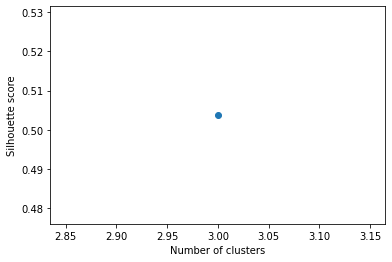

In [15]:
fuzzycmean_final_cluster = [make_fuzzycmean(k) for k in range_k]
sil_scores = np.array([i['sil_score'] for i in fuzzycmean_final_cluster])
plt.plot(range_k, sil_scores)
plt.scatter(range_k, sil_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.savefig('Fuzzy C-Mean sil plot.png')
plt.show()

In [16]:
# sort out according to decreasing sihouette scores
sorted_fuzzycmean_final_cluster = sorted(fuzzycmean_final_cluster, key=lambda x: x['sil_score'], reverse=True)
sorted_fuzzycmean_final_cluster

[{'k': 3,
  'cluster_labels': array([0, 1, 0, ..., 0, 0, 2]),
  'sil_score': 0.5037416662956539}]

In [17]:
# Find the best value
best_k_fuzzycmean = sorted_fuzzycmean_final_cluster[0]['k']
fuzzycmean_cluster_labels = sorted_fuzzycmean_final_cluster[0]['cluster_labels']
fuzzycmean_sil_score = sorted_fuzzycmean_final_cluster[0]['sil_score']
print(f'Số cụm tốt nhất cho KMeans là {best_k_fuzzycmean} với giá trị sihouette: {fuzzycmean_sil_score}')

Số cụm tốt nhất cho KMeans là 3 với giá trị sihouette: 0.5037416662956539


In [18]:
# chạy model
print(f"Chạy model với K = {best_k_fuzzycmean} cho Fuzzy C-Mean")
fcm_model = FCM(n_clusters=best_k_fuzzycmean, random_state=rs)
fcm_model.fit(X)

Chạy model với K = 3 cho Fuzzy C-Mean


In [19]:
# Save the model of FCM
with open('../../data/fuzzycmean_model.pkl', 'wb') as f:
    pickle.dump(fcm_model, f, pickle.HIGHEST_PROTOCOL)

fuzzycmean_cluster_df = pd.DataFrame(
    {'User number': cust_id, 'Cluster Label': fuzzycmean_cluster_labels}
)
df_merged_fuzzy = df.merge(fuzzycmean_cluster_df, on='User number')
df_merged_fuzzy.to_csv('../../data/cluster_fuzzycmean.csv', index=False)

In [20]:
print("Trung bình giá trị trên mỗi cụm của Fuzzy C-Mean")
df_merged_fuzzy.groupby('Cluster Label').mean().iloc[:, 1:]

Trung bình giá trị trên mỗi cụm của Fuzzy C-Mean


,Recency,Frequency,Moneytary
Cluster Label,,,
0,0.020131,0.001805,0.013225
1,0.062664,0.000628,0.010668
2,0.111405,0.000201,0.009454


In [21]:
print("Số lượng khách hàng mỗi cụm")
fuzzycmean_cluster_df.groupby('Cluster Label').count()

Số lượng khách hàng mỗi cụm


,User number
Cluster Label,
0,3680
1,2532
2,2594
